In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARMA
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2021-07-16 17:45:16.037461: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-16 17:45:16.037505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
adjusted = pd.read_csv('prices-split-adjusted.csv')

In [3]:
adjusted.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
temp = adjusted[adjusted['symbol'] == 'WLTW']['open']

In [5]:
n = len(temp)

train_size = int(n * 0.7)
test_size = n - train_size

train_X = temp[ : train_size] 
true_y = temp[train_size : n]

average = sum(train_X) / train_size

pred_y = [average] * test_size

In [6]:
true_y[175]

122.900002

In [7]:
pred_y = {}
for i in range(175, 251):
    pred_y[i] = average

pred_y = pd.DataFrame.from_dict(pred_y, orient='index')

In [8]:
pred_y

,0
175,120.497943
176,120.497943
177,120.497943
178,120.497943
179,120.497943
...,...
246,120.497943
247,120.497943
248,120.497943
249,120.497943


In [51]:
pred_y = pred_y.rename(columns={"predicted prices": "mean"})

In [12]:
pred_y

,predicted prices
175,120.497943
176,120.497943
177,120.497943
178,120.497943
179,120.497943
...,...
246,120.497943
247,120.497943
248,120.497943
249,120.497943


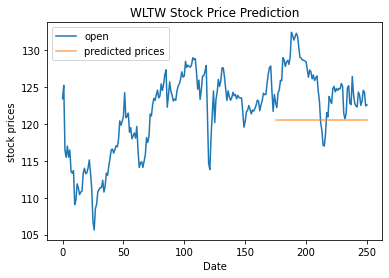

In [42]:

ax = temp.plot(label='observed')
pred_y.plot(ax=ax, label='predicted price', alpha=.7)

# ax.fill_between(pred_y.index,
#                 pred_y.iloc[:, 0],
#                 pred_y.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('stock prices')
plt.legend()
plt.title('WLTW Stock Price Prediction')

plt.show()

In [18]:
 
n = temp.shape[0]

# define X
temp_price = temp.squeeze()

# split test, train set 
train_size = int(n * 0.7)
test_size = n - train_size

train_X = temp_price.iloc[ : train_size] 
true_y = temp_price.iloc[train_size : n]


best_mod = ARMA(train_X, order=(1,4))
best_res = best_mod.fit()
best_result = best_res.predict(start = train_size, end = (n-1)).tolist()

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [20]:
pred_y_1 = {}
for i in range(len(best_result)):
    pred_y_1[175+i] = best_result[i]

pred_y_1 = pd.DataFrame.from_dict(pred_y_1, orient='index')

In [49]:
pred_y_1 = pred_y_1.rename(columns={"predicted prices": "ARMA"})

In [50]:
pred_y_1

,ARMA
175,124.367515
176,124.193662
177,124.159944
178,123.879052
179,123.765542
...,...
246,121.220730
247,121.213684
248,121.206919
249,121.200426


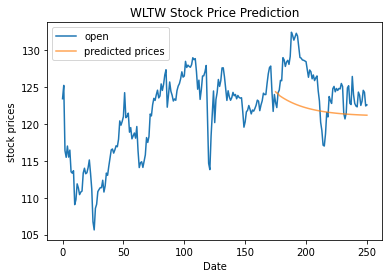

In [43]:
ax = temp.plot(label='observed')
pred_y_1.plot(ax=ax, label='predicted price', alpha=.7)

# ax.fill_between(pred_y.index,
#                 pred_y.iloc[:, 0],
#                 pred_y.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('stock prices')
plt.legend()
plt.title('WLTW Stock Price Prediction')

plt.show()

In [28]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [33]:
temp.values

array([123.43    , 125.239998, 116.379997, 115.480003, 117.010002,
       115.510002, 116.459999, 113.510002, 113.330002, 113.660004,
       109.059998, 109.730003, 111.879997, 111.32    , 110.419998,
       110.769997, 110.900002, 113.349998, 114.      , 113.25    ,
       113.379997, 114.080002, 115.120003, 113.300003, 111.169998,
       106.730003, 105.629997, 108.559998, 109.110001, 110.830002,
       111.120003, 111.370003, 111.360001, 112.370003, 110.769997,
       111.599998, 113.339996, 113.040001, 114.269997, 115.349998,
       116.489998, 116.610001, 116.050003, 116.5     , 117.050003,
       116.910004, 117.93    , 120.419998, 119.839996, 120.349998,
       121.010002, 124.25    , 120.860001, 121.029999, 121.470001,
       118.889999, 119.510002, 117.989998, 118.400002, 118.779999,
       118.080002, 119.660004, 116.400002, 114.089996, 114.739998,
       114.879997, 114.110001, 114.989998, 115.809998, 118.160004,
       117.5     , 118.32    , 121.349998, 121.099998, 122.610

In [36]:
temp = pd.DataFrame(adjusted[adjusted['symbol'] == 'WLTW']['open'])
dataset = temp.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(len(dataset))

    
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

    
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

    
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
    
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

    # #evaluation 
    # best_mse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    # best_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])

    # # store the result in the dataframe evaluation
    # evaluation.loc[evaluation['stock name'] == stock, 'model_3 mse'] = best_mse
    # evaluation.loc[evaluation['stock name'] == stock, 'model_3 mape'] = best_mape

251
2021-07-16 18:13:05.207391: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-16 18:13:05.209553: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-16 18:13:05.209574: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-16 18:13:05.209600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-fb4937d9-4ef1-4542-bee6-529d5ac2a998): /proc/driver/nvidia/version does not exist
2021-07-16 18:13:05.210635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other oper

In [37]:
testPredict[:,0]

array([122.84572 , 122.21923 , 124.069176, 124.404396, 125.58941 ,
       125.53665 , 128.19545 , 127.95739 , 127.207596, 127.71758 ,
       127.89964 , 127.44263 , 128.33418 , 130.89285 , 130.5552  ,
       130.08304 , 130.41898 , 130.78825 , 130.50987 , 129.41467 ,
       128.21997 , 128.14633 , 127.9409  , 127.9079  , 127.825294,
       127.75077 , 126.8436  , 125.94813 , 126.801025, 126.59602 ,
       125.76479 , 126.217255, 125.55424 , 125.878395, 126.104614,
       124.30496 , 123.05    , 120.32465 , 119.24081 , 117.29692 ,
       117.17935 , 118.802765, 121.57713 , 121.01537 , 123.61254 ,
       123.09632 , 122.74329 , 124.575615, 124.853615, 124.19629 ,
       124.602585, 124.35923 , 124.602585, 124.54863 , 125.209785,
       124.853615, 121.46321 , 120.75699 , 121.5107  , 124.67446 ,
       124.934006, 122.752625, 122.603355, 126.04384 , 123.859634,
       122.752625, 122.41628 , 122.30374 , 124.16    , 123.76825 ,
       122.49117 , 123.02217 , 124.3773  , 124.132774], dtype=

In [38]:
pred_y_2 = {}
for i in range(len(testPredict[:,0])):
    pred_y_2[175+i] = testPredict[:,0][i]

pred_y_2 = pd.DataFrame.from_dict(pred_y_2, orient='index')

In [47]:
pred_y_2 = pred_y_2.rename(columns={"predicted prices": "LSTM"})

In [48]:
pred_y_2

,LSTM
175,122.845718
176,122.219231
177,124.069176
178,124.404396
179,125.589409
...,...
244,123.768250
245,122.491173
246,123.022171
247,124.377296


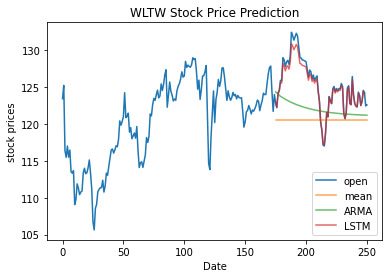

In [52]:
ax = temp.plot(label='observed')
pred_y.plot(ax=ax, label='mean', alpha=.7)
pred_y_1.plot(ax=ax, label='ARMA', alpha=.7)
pred_y_2.plot(ax=ax, label='LSTM', alpha=.7)

# ax.fill_between(pred_y.index,
#                 pred_y.iloc[:, 0],
#                 pred_y.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('stock prices')
plt.legend()
plt.title('WLTW Stock Price Prediction')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb4937d9-4ef1-4542-bee6-529d5ac2a998' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>